<a href="https://colab.research.google.com/github/samsyano/Transfer-Learning-/blob/main/Transfer_Learning_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Transfer Learning

Feature Extraction

In [ ]:
!nvidia-smi

Mon Jun 12 16:01:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()

zip_ref.close()



--2023-06-12 16:01:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  30.6MB/s    in 6.1s    

2023-06-12 16:01:09 (26.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
#  Inspect the data using Walkthrough

import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} Images in {dirpath}")

There are 2 directories and 0 Images in 10_food_classes_10_percent
There are 10 directories and 0 Images in 10_food_classes_10_percent/test
There are 0 directories and 250 Images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 Images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 Images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 Images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 Images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 Images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 Images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 Images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 Images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 Images in 10_food_classes_10_percent/test/chicken_wings
There are 10 directori

In [ ]:
# Setup data Loader (ImageDataGenerator)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMG_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size=IMG_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### Setting up Callbacks

used for Tensorboard callbacks, model checkpoint callbacks, Earlystopping callback for models (to prevent overtraining(overfitting))

In [ ]:
import datetime

# Create directory path for callbacks
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")

  return tensorboard_callback


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

### Create Model from URL

In [ ]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMG_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Fit the Model to data

resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving Tensorboard log files to: tensorflow_hub/resnet50V2/20230612-163538
Epoch 1/5
24/24 [==============================] - 34s 858ms/step - loss: 1.9296 - accuracy: 0.3813 - val_loss: 1.2627 - val_accuracy: 0.6012
Epoch 2/5
24/24 [==============================] - 17s 746ms/step - loss: 0.9373 - accuracy: 0.7227 - val_loss: 0.8968 - val_accuracy: 0.7132
Epoch 3/5
24/24 [==============================] - 19s 794ms/step - loss: 0.6338 - accuracy: 0.8160 - val_loss: 0.7815 - val_accuracy: 0.7420
Epoch 4/5
24/24 [==============================] - 17s 748ms/step - loss: 0.4875 - accuracy: 0.8613 - val_loss: 0.7189 - val_accuracy: 0.7684
Epoch 5/5
24/24 [==============================] - 18s 776ms/step - loss: 0.3877 - accuracy: 0.9040 - val_loss: 0.6901 - val_accuracy: 0.7632


In [ ]:
import matplotlib.pyplot as plt

# Plot loss curves
# Plot the validation and training curves separately
def plot_loss_curves(history):
  """
  Return separate loss curves for training and validation metrics

  Args:
    history: Tensorflow history object

  Returns:
    plot of training/validation loss and accuracy metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()


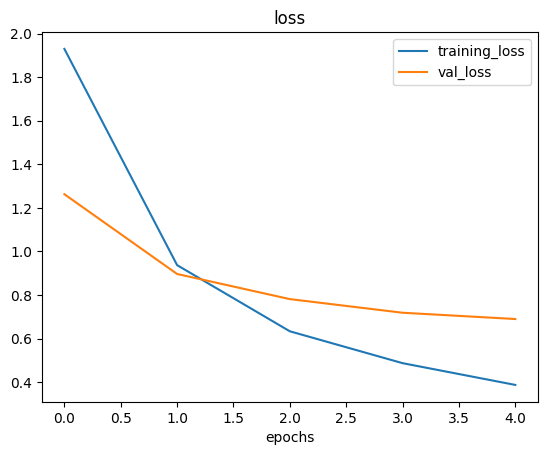

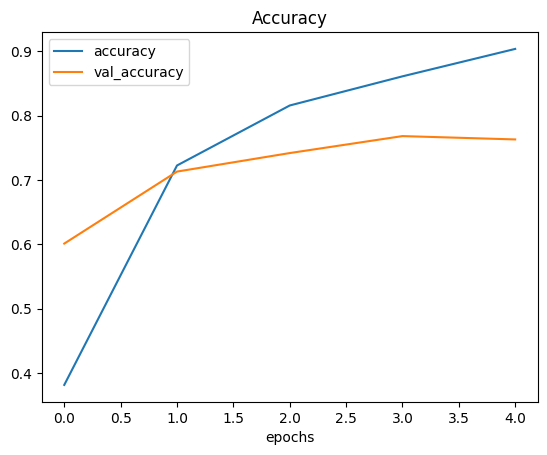

In [ ]:
plot_loss_curves(resnet_history)

### Create EfficientNet Model

In [ ]:
# Create model
efficientnet_model = create_model(efficientnet_url, num_classes=train_data.num_classes)

# Compile
efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             6575232   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 6,588,042
Trainable params: 12,810
Non-trainable params: 6,575,232
_________________________________________________________________


In [ ]:
# Fit model
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                    experiment_name="efficientnetb0")
                                               )

Saving Tensorboard log files to: tensflow_hub/efficientnetb0/20230612-170141
Epoch 1/5
24/24 [==============================] - 37s 913ms/step - loss: 1.8448 - accuracy: 0.4240 - val_loss: 1.2765 - val_accuracy: 0.7184
Epoch 2/5
24/24 [==============================] - 18s 755ms/step - loss: 1.0332 - accuracy: 0.7933 - val_loss: 0.8193 - val_accuracy: 0.8196
Epoch 3/5
24/24 [==============================] - 19s 799ms/step - loss: 0.7240 - accuracy: 0.8387 - val_loss: 0.6567 - val_accuracy: 0.8452
Epoch 4/5
24/24 [==============================] - 17s 740ms/step - loss: 0.5798 - accuracy: 0.8693 - val_loss: 0.5804 - val_accuracy: 0.8524
Epoch 5/5
24/24 [==============================] - 18s 775ms/step - loss: 0.4856 - accuracy: 0.8880 - val_loss: 0.5299 - val_accuracy: 0.8612


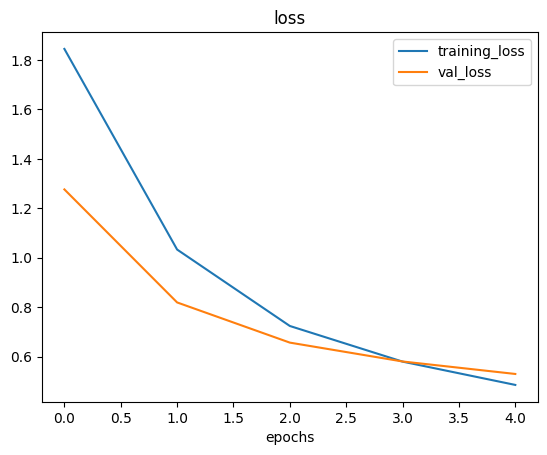

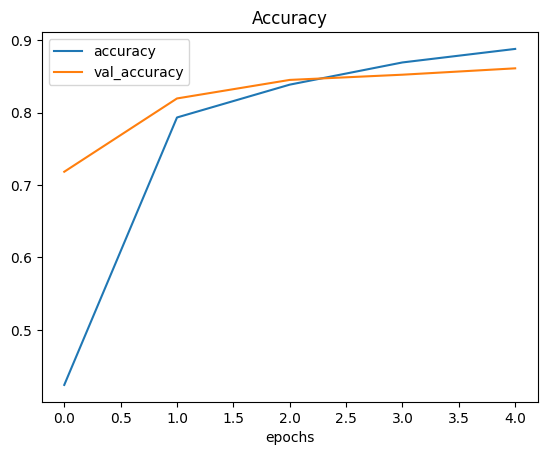

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
len(efficientnet_model.layers[0].weights)

437

In [ ]:
len(resnet_model.layers[0].weights)

270

### Compare Model results using Tensorboard

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNet vs ResNet" \
  --description "Comparing two different TF Hub feature extraction model architectures using Tensorboard" \
  --one_shot

2023-06-12 18:11:30.761639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   YDM-CDZ-QDG



New experiment created. View your TensorBoard at: https://tensorboard.dev/ex

In [ ]:
!tensorboard dev list

2023-06-12 18:15:31.730843: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/f4d7MPkvRVGlO20PsjrvwA/
	Name                 EfficientNet vs ResNet
	Description          Comparing two different TF Hub feature extraction model architectures using Tensorboard
	Id                   f4d7MPkvRVGlO20PsjrvwA
	Created              2023-06-12 18:12:53 (2 minutes ago)
	Updated              2023-06-12 18:12:57 (2 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  7532684
Total: 1 experiment(s)
